# Imports and data loading

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.api as sm
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
import typing

%matplotlib inline
sns.set(style="ticks", color_codes=True)

In [2]:
data = pd.read_csv('../DATA/processed/dataset.csv', parse_dates=['date'])
data = data.set_index('date')

# Preprocessing
Заполняем отсутствующие значения

In [3]:
def prepare_sensors_data(data, columns):
    for c in columns:
        data[c].interpolate(inplace=True)
        data[c].fillna(data[c].mean(), inplace=True)
    return data

В данных метеостанции если признак не меняется в течении нескольких интервалов наблюдений, то колонка не заполняется, а значение помещается в последнию ечейку перед переходом к следующему значению

In [4]:
def prepare_meteo_data(data, columns):
    for c in columns:
        data[c].fillna(method='bfill', inplace=True)
    return data

In [5]:
sensor_columns = ['P1_p10', 'P1_p25', 'P1_p50', 'P1_p75', 'P1_p90', 'P1', 'P1_filtr_mean',
       'P2_p10', 'P2_p25', 'P2_p50', 'P2_p75', 'P2_p90', 'P2', 'P2_filtr_mean',
       'temperature_p10', 'temperature_p25', 'temperature_p50',
       'temperature_p75', 'temperature_p90', 'temperature',
       'temperature_filtr_mean', 'humidity_p10', 'humidity_p25',
       'humidity_p50', 'humidity_p75', 'humidity_p90', 'humidity',
       'humidity_filtr_mean', 'pressure_p10', 'pressure_p25', 'pressure_p50',
       'pressure_p75', 'pressure_p90', 'pressure', 'pressure_filtr_mean']

data = prepare_sensors_data(data, sensor_columns)

In [6]:
meteo_columns = ['temp_meteo', 'pres_meteo', 'hum_meteo', 'wind_direction', 'wind_speed',
       'precipitation', 'prec_amount', 'prec_time', 'visibility',
       'dew_point_temp']

data = prepare_meteo_data(data, meteo_columns)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 127801 entries, 2019-04-01 00:00:00+00:00 to 2020-06-17 18:00:00+00:00
Data columns (total 45 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   P1_p10                  127801 non-null  float64
 1   P1_p25                  127801 non-null  float64
 2   P1_p50                  127801 non-null  float64
 3   P1_p75                  127801 non-null  float64
 4   P1_p90                  127801 non-null  float64
 5   P1                      127801 non-null  float64
 6   P1_filtr_mean           127801 non-null  float64
 7   P2_p10                  127801 non-null  float64
 8   P2_p25                  127801 non-null  float64
 9   P2_p50                  127801 non-null  float64
 10  P2_p75                  127801 non-null  float64
 11  P2_p90                  127801 non-null  float64
 12  P2                      127801 non-null  float64
 13  P2_filtr_mean           1278

# Feature engineering

# Feature engineering

In [8]:
# dict for encoding wind direction troght angle

wind_dir = {'Ветер, дующий с востока': 0,
            'Ветер, дующий с востоко-северо-востока': 45/2,
            'Ветер, дующий с северо-востока': 45,
            'Ветер, дующий с северо-северо-востока': 45 + 45/2,
            'Ветер, дующий с севера': 90,
            'Ветер, дующий с северо-северо-запад': 90 + 45/2,
            'Ветер, дующий с северо-запада': 135,
            'Ветер, дующий с западо-северо-запада': 135 + 45/2,
            'Ветер, дующий с запада': 180,
            'Ветер, дующий с западо-юго-запада': 180+45/2,
            'Ветер, дующий с юго-запада': 225,
            'Ветер, дующий с юго-юго-запада': 225 + 45/2,
            'Ветер, дующий с юга': 270,
            'Ветер, дующий с юго-юго-востока': 270 + 45/2,
            'Ветер, дующий с юго-востока': 315,
            'Ветер, дующий с востоко-юго-востока': 315 + 45/2,
            'Штиль, безветрие': None,
            }

In [9]:
def add_features(data: pd.DataFrame) -> pd.DataFrame:
    """Features preparation for anomaly detection and clustering"""
    
    data['wind_direction'] = data.wind_direction.fillna(method='bfill')
    data['wind_direction'] = data.wind_direction.map(wind_dir)

    data['prec_amount'] = data.prec_amount.fillna(method='bfill')
    data.loc[data.prec_amount == 'Осадков нет', 'prec_amount'] = 0
    data.loc[data.prec_amount == 'Следы осадков', 'prec_amount'] = 0
    data['prec_amount'] = data.prec_amount.astype(float)
    data['prec_time'] = data.prec_time.fillna(method='bfill')
    data['prec_amount'] = data.prec_amount / data.prec_time
    
    data['dew_point_diff'] = data.temp_meteo - data.dew_point_temp
    
    data['P1_iqr_25_75'] = data.P1_p75 - data.P1_p25
    data['P1_iqr_10_90'] = data.P1_p90 - data.P1_p10
    
    data['P2_iqr_25_75'] = data.P2_p75 - data.P2_p25
    data['P2_iqr_10_90'] = data.P2_p90 - data.P2_p10
    
    data['temp_iqr_25_75'] = data.temperature_p75 - data.temperature_p25
    data['temp_iqr_10_90'] = data.temperature_p90 - data.temperature_p10
    
    data['hum_iqr_25_75'] = data.humidity_p75 - data.humidity_p25
    data['hum_iqr_10_90'] = data.humidity_p90 - data.humidity_p10
    
    data["wind_sin"] = np.sin(np.radians(data.wind_direction))
    data["wind_cos"] = np.cos(np.radians(data.wind_direction))
    data['wind_sin'] = data.wind_sin.fillna(value=2)
    data['wind_cos'] = data.wind_cos.fillna(value=2)
    
    return data

In [10]:
data = add_features(data)

In [11]:
data.columns

Index(['P1_p10', 'P1_p25', 'P1_p50', 'P1_p75', 'P1_p90', 'P1', 'P1_filtr_mean',
       'P2_p10', 'P2_p25', 'P2_p50', 'P2_p75', 'P2_p90', 'P2', 'P2_filtr_mean',
       'temperature_p10', 'temperature_p25', 'temperature_p50',
       'temperature_p75', 'temperature_p90', 'temperature',
       'temperature_filtr_mean', 'humidity_p10', 'humidity_p25',
       'humidity_p50', 'humidity_p75', 'humidity_p90', 'humidity',
       'humidity_filtr_mean', 'pressure_p10', 'pressure_p25', 'pressure_p50',
       'pressure_p75', 'pressure_p90', 'pressure', 'pressure_filtr_mean',
       'temp_meteo', 'pres_meteo', 'hum_meteo', 'wind_direction', 'wind_speed',
       'precipitation', 'prec_amount', 'prec_time', 'visibility',
       'dew_point_temp', 'dew_point_diff', 'P1_iqr_25_75', 'P1_iqr_10_90',
       'P2_iqr_25_75', 'P2_iqr_10_90', 'temp_iqr_25_75', 'temp_iqr_10_90',
       'hum_iqr_25_75', 'hum_iqr_10_90', 'wind_sin', 'wind_cos'],
      dtype='object')

In [12]:
sel_columns = ['P1_filtr_mean', 'P2_filtr_mean',
       'temperature_filtr_mean', 'humidity_filtr_mean', 'temp_meteo', 'pres_meteo', 'hum_meteo', 'wind_speed',
       'prec_amount',  'dew_point_temp', 'P1_iqr_25_75', 'P1_iqr_10_90', 'P2_iqr_25_75',
       'P2_iqr_10_90', 'temp_iqr_25_75', 'temp_iqr_10_90', 'hum_iqr_25_75',
       'hum_iqr_10_90', 'dew_point_diff', 'prec_time', 'wind_sin', 'wind_cos', 'wind_direction']

data = data[sel_columns]

# Anomaly detection
Разбиваем датефрейм на части по 7 дней, для каждой части делаем декомпозицию и смотрим на residual. Там, где выходит за 85-ый квантиль, считаем что есть аномалия.

In [13]:
def anom_detector(time_series: pd.DataFrame, freq=round(60 * 25 / 5), quant=0.85) -> typing.List[pd.DataFrame]:
    """
    Anomaly detection by time-series decomposition.
    :param time_series: to series for anomaly search
    :param freq: frequency of decomposition
    :param quant: al moment with decomposition residual above this quantile is anomaly
    :return: list of anomaly series
    """
    time_series['P1_filtr_mean'] = time_series.P1_filtr_mean.interpolate()
    time_series['P1_filtr_mean'] = time_series.P1_filtr_mean.rolling(4, min_periods=1).mean()
    decomp = sm.tsa.seasonal_decompose(time_series.P1_filtr_mean, model='additive', freq=freq, extrapolate_trend='freq')
    q = decomp.resid.quantile(quant)

    # find anomaly
    time_series['trend'] = decomp.trend
    time_series['seasonal'] = decomp.seasonal
    time_series['resid'] = decomp.resid
    time_series['anomaly'] = abs(time_series.resid) > q
    anomaly = time_series[time_series['anomaly']]

    # split anomaly on separate dataframe
    anomaly['gap'] = (anomaly.index.to_series().diff()) > pd.Timedelta(10, 'm')
    l_mod = pd.to_datetime(anomaly[anomaly.gap].index)
    l_mod = l_mod.insert(0, anomaly.index[0])
    l_mod = l_mod.insert(len(l_mod), anomaly.index[-1])
    ls = [anomaly[l_mod[n]:l_mod[n + 1]] for n in range(0, len(l_mod) - 1, 1)]
    ls = [i[:-1] for i in ls]
    ls = [i for i in ls if len(i) > 12]
    return ls

In [14]:
weeks = [g for n, g in data.groupby(pd.Grouper(freq='7D'))]  # split dataset by 7 days series
anom_list = []
# for each series detect anomalies separately
for w in weeks[:-2]:
    # decomposition
    ls = anom_detector(w)
    anom_list = anom_list + ls

//home/anatoly/HDD/anaconda3/envs/mlforair/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  # This is added back by InteractiveShellApp.init_path()
//home/anatoly/HDD/anaconda3/envs/mlforair/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


посмотрим, что получилось

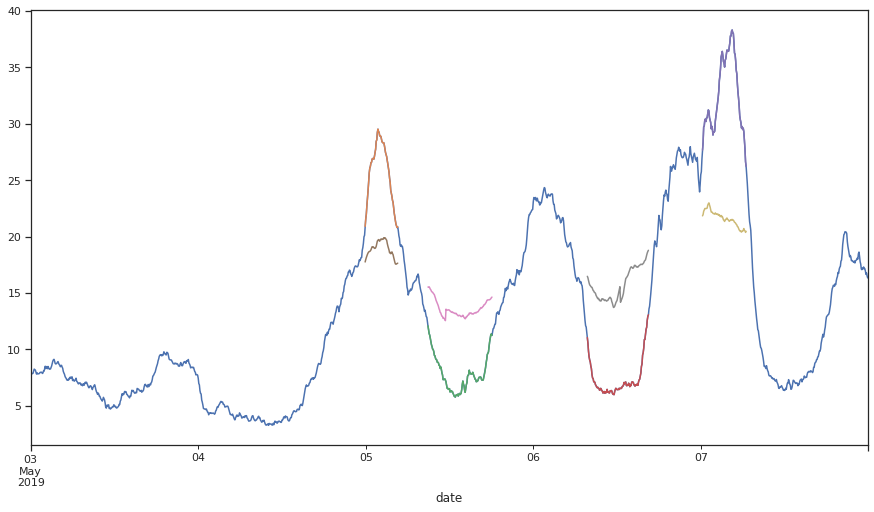

In [15]:
plt.figure(figsize=(15,8))
data['2019-05-3':'2019-05-7'].P1_filtr_mean.plot()
anom_list[65].P1_filtr_mean.plot()
anom_list[66].P1_filtr_mean.plot()
anom_list[67].P1_filtr_mean.plot()
anom_list[68].P1_filtr_mean.plot()
(anom_list[65].trend+anom_list[65].seasonal).plot()
(anom_list[66].trend+anom_list[66].seasonal).plot()
(anom_list[67].trend+anom_list[67].seasonal).plot()
(anom_list[68].trend+anom_list[68].seasonal).plot()

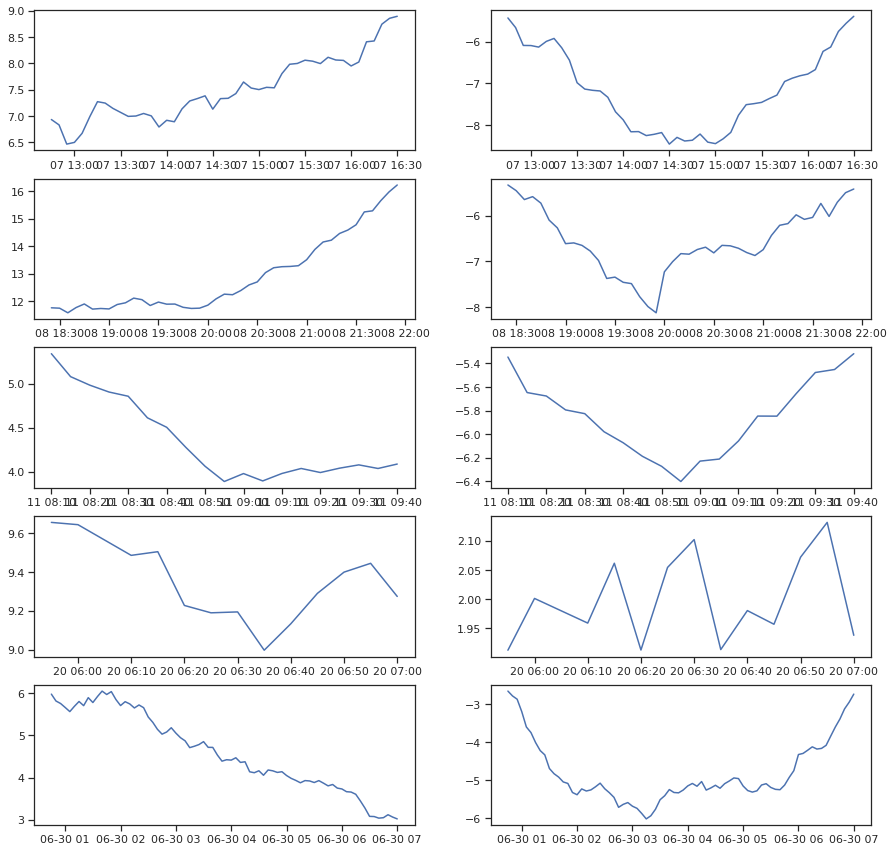

In [16]:
f, axs = plt.subplots(5,2,figsize=(15,15))
ax = 0
for i in [70, 71, 80, 91, 174]:
    axs[ax,0].plot(anom_list[i].P1_filtr_mean)
    axs[ax,1].plot(anom_list[i].resid)
    ax += 1

# Anomaly clustering
Собираем датафрейм с признаками аномалий

In [17]:
def get_anomaly_features(anom_list: typing.List[pd.DataFrame]) -> pd.DataFrame:
    anomdata = pd.DataFrame(index=[i for i in range(len(anom_list))])
    anomdata['resid_change'] = [i.loc[i.resid.abs().idxmax()].resid -
                         i.loc[i.resid.abs().idxmin()].resid for i in anom_list]
    
    anomdata['hum'] = [i.loc[i.resid.abs().idxmax()].hum_meteo -
                       i.loc[i.resid.abs().idxmin()].hum_meteo for i in anom_list]
    
    anomdata['temp'] = [i.loc[i.resid.abs().idxmax()].temp_meteo -
                        i.loc[i.resid.abs().idxmin()].temp_meteo for i in anom_list]
    
    anomdata['prec'] = [i.loc[i.resid.abs().idxmax()].prec_amount -
                        i.loc[i.resid.abs().idxmin()].prec_amount for i in anom_list]
    
    anomdata['wind_speed'] = [i.loc[i.resid.abs().idxmax()].wind_speed -
                        i.loc[i.resid.abs().idxmin()].wind_speed for i in anom_list]
    
    anomdata['wind_sin'] = [i.loc[i.resid.abs().idxmax()].wind_sin -
                        i.loc[i.resid.abs().idxmin()].wind_sin for i in anom_list]
    anomdata['wind_cos'] = [i.loc[i.resid.abs().idxmax()].wind_cos -
                        i.loc[i.resid.abs().idxmin()].wind_cos for i in anom_list]
    return anomdata

In [18]:
anomdata = get_anomaly_features(anom_list)

In [19]:
anomdata.head()

,resid_change,hum,temp,prec,wind_speed,wind_sin,wind_cos
0,2.590064,-7,0.0,0.025,1,-0.765367,-1.110223e-16
1,-1.171760,-9,0.7,0.025,1,0.382683,7.612047e-02
2,2.163839,-25,4.4,0.000,0,0.076120,-3.826834e-01
3,1.181322,0,0.0,0.000,0,0.000000,0.000000e+00
4,3.468826,-25,5.6,0.000,2,-0.617317,9.238795e-01


In [20]:
def dimension_reduction(anomdata: pd.DataFrame, n_comp) -> (PCA, np.array, float):

    pca = PCA(n_components=n_comp)
    pca.fit(anomdata)
    x = pca.transform(anomdata)
    score = 1 - pca.explained_variance_ratio_[-1]
    return pca, x, score

выбираем фичи, по котрым делаем кластеризацию, снижаем размерность с помощью PCA

In [21]:
sel_columns = ['change_w_speed', 'change_hum', 'max_resid', 'min_resid', 'change_temp',# 'prec_time',
               #'max_p1_iqr1', 'min_p1_iqr1', 'max_p1_iqr2', 'min_p1_iqr2',
               #'max_p2_iqr1', 'min_p2_iqr1', 'max_p2_iqr2', 'min_p2_iqr2',
               #'max_temp_iqr1', 'min_temp_iqr1', 'max_temp_iqr2', 'min_temp_iqr2',
               #'max_hum_iqr1', 'min_hum_iqr1', 'max_hum_iqr2', 'min_hum_iqr2',
              ]
sel_columns = ['mean_hum', 'prec_amount',
               'max_w_speed', 'min_w_speed', 'change_hum', 'max_resid', 'min_resid', 'prec_time']

In [22]:
pca, X, pca_score = dimension_reduction(anomdata, n_comp=3)

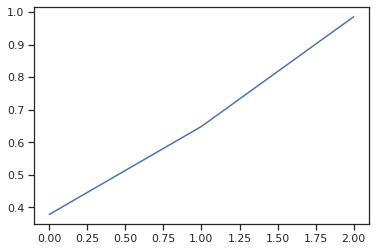

In [23]:
plt.plot(1-pca.explained_variance_ratio_)

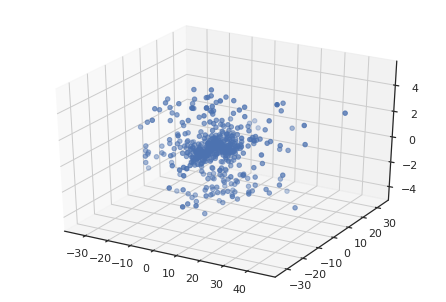

In [24]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:,0], X[:,1], X[:,2])

определии количество кластеров с помощью  elbow method и silhouette_score

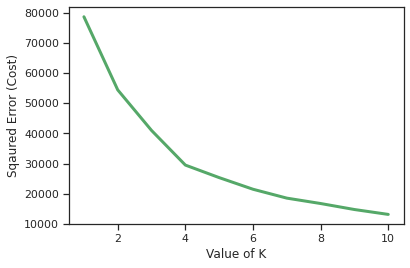

In [25]:
cost =[]
silh = []
for i in range(1, 11): 
    KM = KMeans(n_clusters = i, max_iter = 500, random_state=42) 
    KM.fit(X) 
      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)
  
# plot the cost against K values 
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 

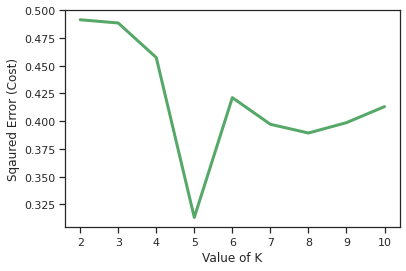

In [26]:
silh = []
for i in range(2, 11): 
    KM = KMeans(n_clusters = i, max_iter = 500, random_state=42) 
    KM.fit(X) 
      
    # calculates squared error 
    # for the clustered points 
    silh.append(silhouette_score(X, KM.labels_, random_state=42))
  
# plot the cost against K values 
plt.plot(range(2, 11), silh, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot  

Из сопоставления этих графиков(точки перегиба и максимума) видим , что оптимальное число кластеров 4. Выполняем кластризацию

In [27]:
def clustering(x: np.array, n_clusters=4, random_state=42) -> (KMeans, float, float):
    km = KMeans(n_clusters=n_clusters, random_state=random_state)
    km.fit(x)
    score = km.inertia_
    silh_score = silhouette_score(x, km.labels_, random_state=random_state)
    return km, score, silh_score

In [28]:
KM, score, silh_score = clustering(X, n_clusters=4)

In [29]:
anomdata['cluster'] = KM.labels_

In [30]:
anomdata.cluster.value_counts()

0    454
1    115
2     80
3     62
Name: cluster, dtype: int64

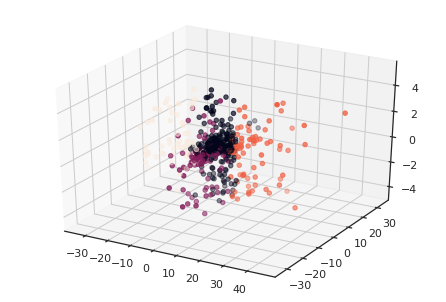

In [31]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:,0], X[:,1], X[:,2], c=anomdata['cluster'].values)
#plt.scatter(X[:,0], X[:,1], c=anomdata['cluster'].values)

Будем нумеровать кластеры по возрастанию resid

In [32]:
clust_prop = anomdata.groupby(['cluster']).mean().sort_values('resid_change').reset_index()

In [33]:
cluster_map = {}
for i in range(len(clust_prop)):
    cluster_map[int(clust_prop.iloc[i].cluster)] = i
cluster_map

{0: 0, 3: 1, 2: 2, 1: 3}

Посмотрим, как распределились средние значения признаков, которые мы использовали для кластеризации по кластерам

In [34]:
clust_prop.cluster.map(cluster_map)

0    0
1    1
2    2
3    3
Name: cluster, dtype: int64

In [35]:
anomalies = anom_list[0]
anomalies['cluster'] = anomdata.cluster.values[0]
for i in range(1, len(anom_list)):
    anom_list[i]['cluster'] = anomdata.cluster.values[i]
    anomalies = anomalies.append(anom_list[i])

In [36]:
anomalies['cluster'] = anomalies.cluster.map(cluster_map)

Посмотрим средние значения признаков для каждого кластера

In [37]:
anomdata.groupby(['cluster']).mean()

,resid_change,hum,temp,prec,wind_speed,wind_sin,wind_cos
cluster,,,,,,,
0,-1.434015,0.149780,-0.084141,0.000018,-0.019824,0.024806,0.010795
1,10.047410,1.165217,-0.192174,0.001304,-0.086957,0.241817,0.151565
2,1.153088,16.575000,-2.885000,0.010104,-0.337500,0.380363,0.400583
3,-0.043877,-15.096774,2.625806,0.008602,0.419355,-0.611997,-0.716579


In [38]:
anomalies.head()

,P1_filtr_mean,P2_filtr_mean,temperature_filtr_mean,humidity_filtr_mean,temp_meteo,pres_meteo,hum_meteo,wind_speed,prec_amount,dew_point_temp,...,prec_time,wind_sin,wind_cos,wind_direction,trend,seasonal,resid,anomaly,gap,cluster
date,,,,,,,,,,,,,,,,,,,,,
2019-04-01 04:40:00+00:00,3.015750,1.1225,5.5925,60.2625,4.5,99724.856,61,2,0.0,-2.4,...,12.0,0.382683,-0.92388,157.5,1.278971,-2.284845,4.021624,True,False,0
2019-04-01 04:45:00+00:00,3.140125,1.0110,5.2925,61.5375,4.5,99724.856,61,2,0.0,-2.4,...,12.0,0.382683,-0.92388,157.5,1.295108,-2.616691,4.461707,True,False,0
2019-04-01 04:50:00+00:00,3.037625,1.0140,5.5425,60.7900,4.5,99724.856,61,2,0.0,-2.4,...,12.0,0.382683,-0.92388,157.5,1.311246,-2.691513,4.417892,True,False,0
2019-04-01 04:55:00+00:00,3.107125,0.9910,5.4450,59.8200,4.5,99724.856,61,2,0.0,-2.4,...,12.0,0.382683,-0.92388,157.5,1.327384,-2.650289,4.430030,True,False,0
2019-04-01 05:00:00+00:00,3.050000,0.9125,5.4000,59.8400,4.5,99724.856,61,2,0.0,-2.4,...,12.0,0.382683,-0.92388,157.5,1.343522,-2.893674,4.600152,True,False,0


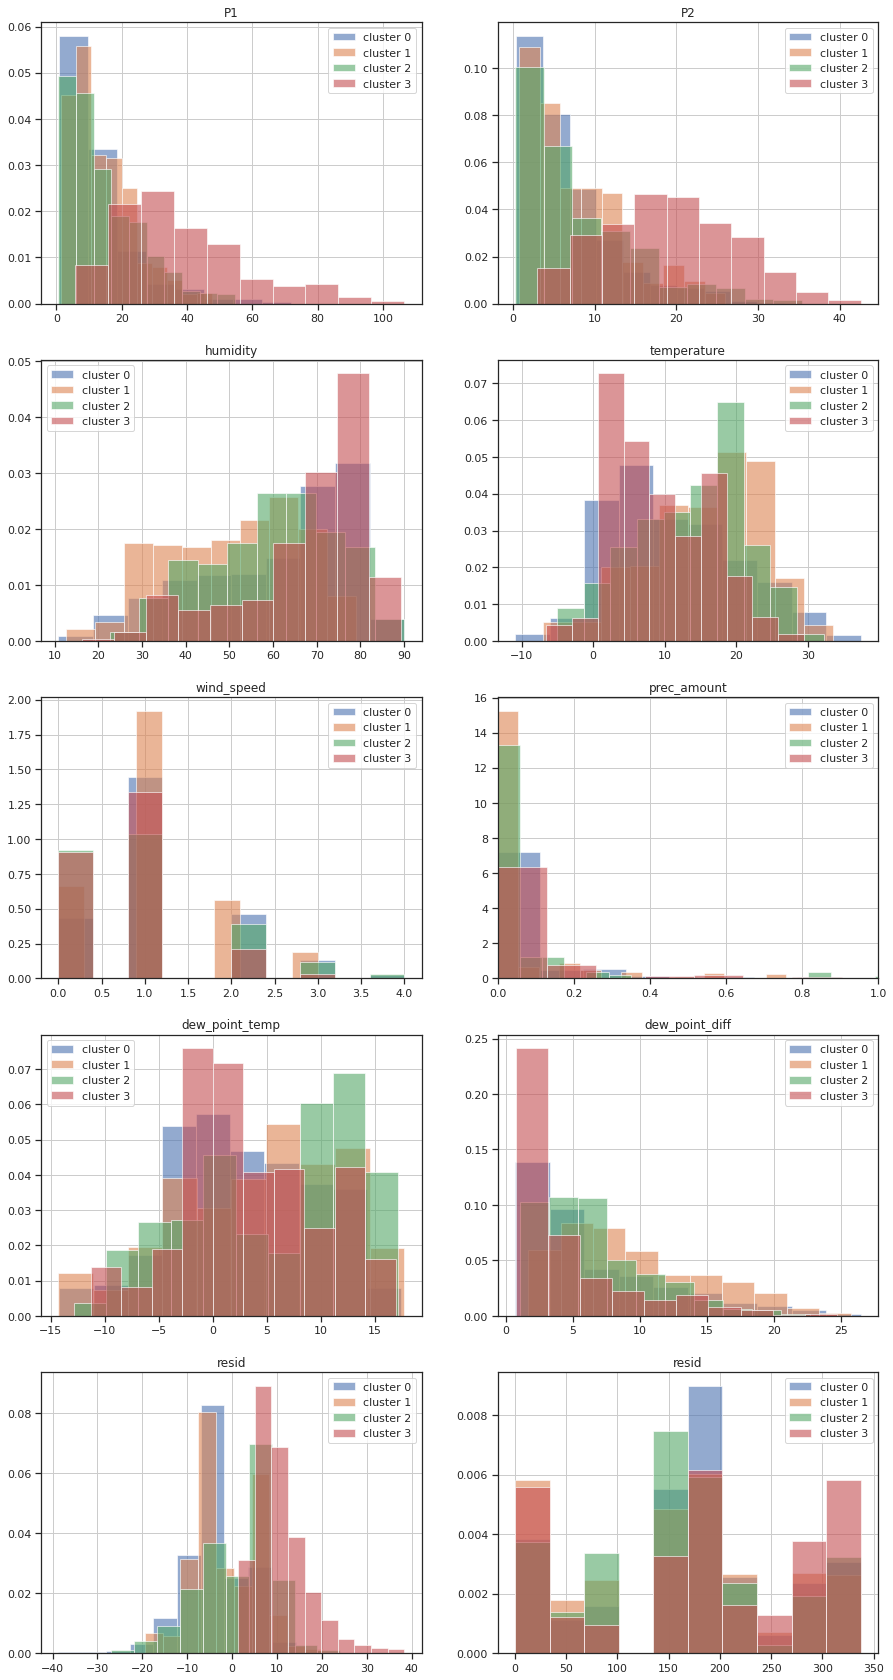

In [39]:
f, axs = plt.subplots(5,2,figsize=(15,30))
n_clast = 4
for i in range(n_clast):
    anomalies[anomalies.cluster == i].P1_filtr_mean.hist(ax=axs[0, 0], alpha = 0.6, label=f'cluster {i}', density=True)
axs[0, 0].set_title('P1')
axs[0, 0].legend(loc = 'best')

for i in range(n_clast):
    anomalies[anomalies.cluster == i].P2_filtr_mean.hist(ax=axs[0, 1], alpha = 0.6, label=f'cluster {i}', density=True)
axs[0, 1].set_title('P2')
axs[0, 1].legend(loc = 'best')

for i in range(n_clast):
    anomalies[anomalies.cluster == i].humidity_filtr_mean.hist(ax=axs[1, 0], alpha = 0.6, label=f'cluster {i}', density=True)
axs[1, 0].set_title('humidity')
axs[1, 0].legend(loc = 'best')

for i in range(n_clast):
    anomalies[anomalies.cluster == i].temperature_filtr_mean.hist(ax=axs[1, 1], alpha = 0.6, label=f'cluster {i}', density=True)
axs[1, 1].set_title('temperature')
axs[1, 1].legend(loc = 'best')

for i in range(n_clast):
    anomalies[anomalies.cluster == i].wind_speed.hist(ax=axs[2, 0],bins=10, alpha = 0.6, label=f'cluster {i}', density=True)
axs[2, 0].set_title('wind_speed')
axs[2, 0].legend(loc = 'best')

for i in range(n_clast):
    anomalies[anomalies.cluster == i].prec_amount.hist(ax=axs[2, 1], bins=20, alpha = 0.6, label=f'cluster {i}', density=True)
axs[2, 1].set_title('prec_amount')
axs[2, 1].set_xlim([0, 1])
axs[2, 1].legend(loc = 'best')

for i in range(n_clast):
    anomalies[anomalies.cluster == i].dew_point_temp.hist(ax=axs[3, 0], alpha = 0.6, label=f'cluster {i}', density=True)
axs[3, 0].set_title('dew_point_temp')
axs[3, 0].legend(loc = 'best')

for i in range(n_clast):
    anomalies[anomalies.cluster == i].dew_point_diff.hist(ax=axs[3, 1], alpha = 0.6, label=f'cluster {i}', density=True)
axs[3, 1].set_title('dew_point_diff')
axs[3, 1].legend(loc = 'best')

for i in range(n_clast):
    anomalies[anomalies.cluster == i].resid.hist(ax=axs[4, 0], alpha = 0.6, label=f'cluster {i}', density=True)
axs[4, 0].set_title('resid')
axs[4, 0].legend(loc = 'best')

for i in range(n_clast):
    anomalies[anomalies.cluster == i].wind_direction.hist(ax=axs[4, 1], alpha = 0.6, label=f'cluster {i}', density=True)
axs[4, 1].set_title('resid')
axs[4, 1].legend(loc = 'best')

Таким образом, для кластеров 0, 1 характерно понижение значения концентрации частиц, а для 2 и 3 повышение. Причем для кластера 3 харакетерно существенное отличие формы распределений P1 и P2.

Так же для кластера 3 характерны высокая влажность, не высокая темпераура, наличие осадков и низкая разность температуры и температуры точки росы. Поэтому аномалии из этого кластера можно интерпретировать как завышенные показания датчиков из-за наличия в воздухе капелек воды.

Кластер 2 харатеризуется повышением концентрации частиц Р1 и Р2 при относительно низких скорости ветра, влажности и небольшом количестве осадков, что позволяет сделать вывод о высокой концентрации пыли в воздухе для аномалий этого типа.

Кластер 1 соответсвует снижению концентрации частиц, причиной которого можно назвать достаточно высокие значения скорости ветра.

Кластер 0 так же имеет относительно высокую скорость ветра, но в дополнение к нему здесь присутсвуют высокие значения количества осадков, которые так же способствуют понижению концентрации частиц.